In [7]:
import io

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
from matplotlib import gridspec, patches
import numpy as np
import os
from xml.etree import ElementTree
from PIL import Image

In [8]:
import math
from torch import default_generator, randperm
from torch._utils import _accumulate
from torch.utils.data.dataset import Subset

def random_split(dataset, lengths,
                 generator=default_generator):
    r"""
    Randomly split a dataset into non-overlapping new datasets of given lengths.

    If a list of fractions that sum up to 1 is given,
    the lengths will be computed automatically as
    floor(frac * len(dataset)) for each fraction provided.

    After computing the lengths, if there are any remainders, 1 count will be
    distributed in round-robin fashion to the lengths
    until there are no remainders left.

    Optionally fix the generator for reproducible results, e.g.:

    >>> random_split(range(10), [3, 7], generator=torch.Generator().manual_seed(42))
    >>> random_split(range(30), [0.3, 0.3, 0.4], generator=torch.Generator(
    ...   ).manual_seed(42))

    Args:
        dataset (Dataset): Dataset to be split
        lengths (sequence): lengths or fractions of splits to be produced
        generator (Generator): Generator used for the random permutation.
    """
    if math.isclose(sum(lengths), 1) and sum(lengths) <= 1:
        subset_lengths: List[int] = []
        for i, frac in enumerate(lengths):
            if frac < 0 or frac > 1:
                raise ValueError(f"Fraction at index {i} is not between 0 and 1")
            n_items_in_split = int(
                math.floor(len(dataset) * frac)  # type: ignore[arg-type]
            )
            subset_lengths.append(n_items_in_split)
        remainder = len(dataset) - sum(subset_lengths)  # type: ignore[arg-type]
        # add 1 to all the lengths in round-robin fashion until the remainder is 0
        for i in range(remainder):
            idx_to_add_at = i % len(subset_lengths)
            subset_lengths[idx_to_add_at] += 1
        lengths = subset_lengths
        for i, length in enumerate(lengths):
            if length == 0:
                warnings.warn(f"Length of split at index {i} is 0. "
                              f"This might result in an empty dataset.")

    # Cannot verify that dataset is Sized
    if sum(lengths) != len(dataset):    # type: ignore[arg-type]
        raise ValueError("Sum of input lengths does not equal the length of the input dataset!")

    indices = randperm(sum(lengths), generator=generator).tolist()  # type: ignore[call-overload]
    return [Subset(dataset, indices[offset - length : offset]) for offset, length in zip(_accumulate(lengths), lengths)]

In [9]:
class PKWholeDataset:
  def __init__(self, root, transform = None):
    self.images = []
    self.labels = []
    self.image_metadata = []
    self.transform = transform
    for filename in os.scandir(root):
      #Ignore top level files
      if filename.is_dir():
        self.load_dir(filename)

  def load_dir(self, directory: os.DirEntry):
    for entry in os.scandir(directory):
      if entry.is_file():
        if entry.name.endswith('.jpg'):
          #Labels are the directory names, except for the file name
          labels: [str] = entry.path.split(os.sep)
          #Filename
          labels.pop(-1)
          #Misc directories that aren't labels
          not_labels = ["PKLot", "PkLot", ".", "PKLotSegmented"]
          for not_label in not_labels:
            try:
              labels.remove(not_label)
            except ValueError:
              continue
          labels = list(set(labels))
          self.images.append(entry)
          self.labels.append(labels)
          metadata_file = entry.path.replace(".jpg", ".xml")
          self.image_metadata.append(metadata_file)
          # just make sure that the labels and entries match up
          assert len(self.images) == len(self.labels)
      elif entry.is_dir():
        self.load_dir(entry)

  def __len__(self):
    return len(self.images)

  #Loads images from FS rather than from memory
  def __getitem__(self, index):
    file = open(self.images[index].path, mode='rb')
    image = Image.open(io.BytesIO(file.read()))
    if self.transform is not None:
      image = self.transform(image)
    occupied = self.get_label(index)
    return image, occupied

  def get_image(self, index):
      file = open(self.images[index].path, mode='rb')
      image = Image.open(io.BytesIO(file.read()))
      return image

  def get_label(self, index):
    doc = ElementTree.parse(pk_whole_dataset.get_metadata(index))
    occupied = 0
    for space in doc.getroot().iter('space'):
        occupied += int(space.get('occupied'))
    return occupied

  def get_metadata(self, index):
    return self.image_metadata[index]

In [10]:
class PKSegmentedDataset:
    def __init__(self, root, transform = None):
        self.images = []
        self.labels = []
        self.transform = transform
        for filename in os.scandir(root):
            #Ignore top level files
            if filename.is_dir():
                self.load_dir(filename)

    def load_dir(self, directory: os.DirEntry):
        for entry in os.scandir(directory):
            if entry.is_file():
                if entry.name.endswith('.jpg'):
                    #Labels are the directory names, except for the file name
                    labels: [str] = entry.path.split(os.sep)
                    #Filename
                    labels.pop(-1)
                    #Misc directories that aren't labels
                    not_labels = ["PKLot", "PkLot", ".", "PKLotSegmented"]
                    for not_label in not_labels:
                        try:
                            labels.remove(not_label)
                        except ValueError:
                            continue
                    labels = list(set(labels))
                    self.images.append(entry)
                    self.labels.append(labels)
                    # just make sure that the labels and entries match up
                    assert len(self.images) == len(self.labels)
            elif entry.is_dir():
                self.load_dir(entry)

    def __len__(self):
        return len(self.images)

    #Loads images from FS rather than from memory
    def __getitem__(self, index):
        file = open(self.images[index].path, mode='rb')
        image = Image.open(io.BytesIO(file.read()))
        if self.transform is not None:
            image = self.transform(image)
        label = self.get_label(index)
        return image, label

    def get_image(self, index):
        file = open(self.images[index].path, mode='rb')
        image = Image.open(io.BytesIO(file.read()))
        return image

    def get_label(self, index):
        #For segmented image, label is 1 if the space is occupied, 0 if unoccupied
        label = 0
        if "Occupied" in self.labels[index]:
            label = 1
        return label

In [11]:
batch_size=1

whole_transform = T.Compose([T.Resize((720, 1280)), T.ToTensor()])
segmented_transform = T.Compose([T.Resize((48, 64)), T.ToTensor()])

pk_whole_dataset = PKWholeDataset('./PKLot/PKLot', whole_transform)
pk_segmented_dataset = PKSegmentedDataset('./PKLot/PKLotSegmented', segmented_transform)

pk_seg_test_dataset, pk_seg_train_dataset = random_split(pk_segmented_dataset, [0.3, 0.7])

pk_whole_loader = torch.utils.data.DataLoader(pk_whole_dataset, batch_size=batch_size, pin_memory=True)
pk_segmented_test_loader = torch.utils.data.DataLoader(pk_seg_test_dataset, batch_size=batch_size, pin_memory=True)
pk_segmented_train_loader = torch.utils.data.DataLoader(pk_seg_train_dataset, batch_size=batch_size, pin_memory=True)


0; 39
1; 33
2; 40
3; 40
4; 3
5; 7
6; 5
7; 0
8; 5
9; 6
10; 0
11; 38


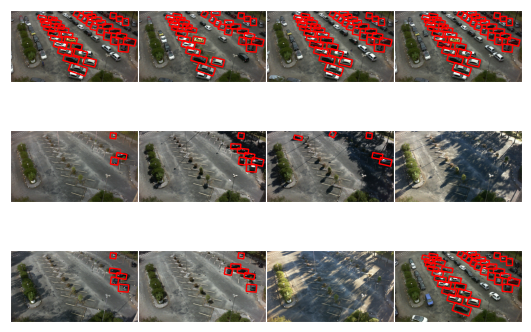

In [12]:
nrow = 3
ncol = 4
gs = gridspec.GridSpec(nrow, ncol,
                       wspace=0.0, hspace=0.0,
                       top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1),
                       left=0.5/(ncol+1), right=1-0.5/(ncol+1))
for i in range(0, nrow):
  for j in range(0, ncol):
    ax = plt.subplot(gs[i, j])
    plt.xticks([])
    plt.yticks([])
    ax.imshow(pk_whole_dataset.get_image((i * ncol + j) * 20))
    doc = ElementTree.parse(pk_whole_dataset.get_metadata((i * ncol + j) * 20))
    occupied = pk_whole_dataset.get_label((i*ncol + j) * 20)
    for space in doc.getroot().iter('space'):
      if int(space.get('occupied')) > 0:
        rect = space.find('rotatedRect')
        center = rect.find('center')
        size = rect.find('size')
        angle = rect.find('angle')
        bottom_left_x = int(center.get("x")) - (int(size.get("w")) / 2)
        bottom_left_y = int(center.get("y")) - (int(size.get("h")) / 2)
        ax.add_patch(patches.Rectangle(xy = (bottom_left_x, bottom_left_y),
                                       width=int(size.get("w")),
                                       height=int(size.get("h")),
                                       angle=float(angle.get("d")),
                                       rotation_point="center",
                                       color="red",
                                       fill=False))
    print(f"{(i*ncol + j)}; {occupied}".format())
plt.show()

0; 1
1; 1
2; 1
3; 1
4; 1
5; 0
6; 1
7; 1
8; 0
9; 0
10; 0
11; 0


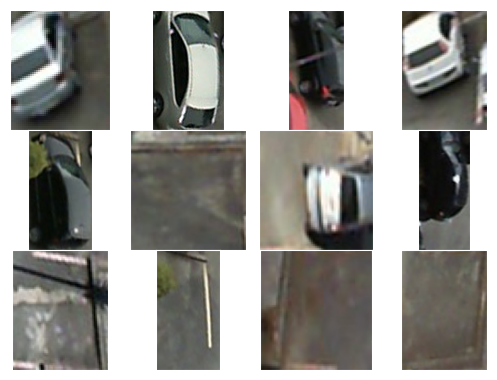

torch.Size([3, 48, 64])


In [13]:
nrow = 3
ncol = 4
gs = gridspec.GridSpec(nrow, ncol,
                       wspace=0.0, hspace=0.0,
                       top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1),
                       left=0.5/(ncol+1), right=1-0.5/(ncol+1))
for i in range(0, nrow):
    for j in range(0, ncol):
        ax = plt.subplot(gs[i, j])
        plt.xticks([])
        plt.yticks([])
        ax.imshow(pk_segmented_dataset.get_image((i * ncol + j) * 500))
        occupied = pk_segmented_dataset.get_label((i*ncol + j) * 500)
        print(f"{(i*ncol + j)}; {occupied}".format())
plt.show()
print(pk_seg_train_dataset[0][0].size())

In [14]:
# Define a convolution neural network
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=5, stride=1, padding=2, padding_mode="zeros")
        self.bn1 = nn.BatchNorm2d(10)
        #ReLU
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5, stride=1, padding=2, padding_mode="zeros")
        self.bn2 = nn.BatchNorm2d(20)
        #ReLU
        self.conv3 = nn.Conv2d(in_channels=20, out_channels=30, kernel_size=5, stride=1, padding=2, padding_mode="zeros")
        self.bn3 = nn.BatchNorm2d(30)
        #ReLU
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(30*24*32*batch_size, 20)
        #ReLU
        self.linear2 = nn.Linear(20, 10)
        #ReLU
        self.linear3 = nn.Linear(10, 2)
        #ReLU
        self.soft_max = nn.Softmax(dim=1)

    def forward(self, input):
        # print(input.size())
        output = F.relu(self.bn1(self.conv1(input)))
        # print(output.size())
        output = F.relu(self.bn2(self.conv2(output)))
        # print(output.size())
        output = self.pool(F.relu(self.bn3(self.conv3(output))))
        # print(output.size())
        output = self.flatten(output)
        # print(output.size())
        output = F.relu(self.linear1(output))
        output = F.relu(self.linear2(output))
        output = F.relu(self.linear3(output))
        output = self.soft_max(output)
        # print(output.size())
        return output.float()

model = Network()

In [15]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        if torch.cuda.is_available():
            X = X.cuda()
            y = y.cuda()
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            if torch.cuda.is_available():
                 X = X.cuda()
                 y = y.cuda()
            pred = model(X)
            if torch.cuda.is_available():
                pred.cuda()
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-07)

In [17]:
if torch.cuda.is_available():
    model.to("cuda")
    torch.backends.cudnn.enabled = False

epochs = 5
for t in range(epochs):
    file = './models/Model_Epoch_' + str(t) + '.pt'
    loaded = False
    try:
        loaded_data = torch.load(file)
        loaded = True
        model.load_state_dict(loaded_data["model_state_dict"])
        optimizer.load_state_dict(loaded_data["optimizer_state_dict"])
        print("Model loaded")
    except Exception as e:
        print("Error loading model: " + str(e))

    if not loaded:
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(pk_segmented_train_loader, model, loss_fn, optimizer)
        test_loop(pk_segmented_test_loader, model, loss_fn)
        torch.save({
            'epoch': t,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, './models/Model_Epoch_' + str(t) + ".pt")
print("Done!")

Model loaded
Model loaded
Model loaded
Model loaded
Error loading model: [Errno 2] No such file or directory: './models/Model_Epoch_4.pt'
Epoch 5
-------------------------------
loss: 0.313292  [    0/487095]
loss: 0.313263  [  100/487095]
loss: 0.313290  [  200/487095]
loss: 0.313352  [  300/487095]
loss: 0.313292  [  400/487095]
loss: 0.313278  [  500/487095]
loss: 0.313280  [  600/487095]
loss: 0.313265  [  700/487095]
loss: 0.313291  [  800/487095]
loss: 0.313269  [  900/487095]
loss: 0.313289  [ 1000/487095]
loss: 0.313272  [ 1100/487095]
loss: 0.313295  [ 1200/487095]
loss: 0.323910  [ 1300/487095]
loss: 0.313286  [ 1400/487095]
loss: 0.313264  [ 1500/487095]
loss: 0.313268  [ 1600/487095]
loss: 0.313272  [ 1700/487095]
loss: 0.313283  [ 1800/487095]
loss: 0.313263  [ 1900/487095]
loss: 0.313411  [ 2000/487095]
loss: 0.313326  [ 2100/487095]
loss: 0.313265  [ 2200/487095]
loss: 0.313294  [ 2300/487095]
loss: 0.315765  [ 2400/487095]
loss: 0.313329  [ 2500/487095]
loss: 0.313288  